In [80]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [84]:
class Network:
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.tanh(np.dot(w, a) + b)
        return a
    
    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def tanh(self, z):
        return np.tanh(z)
    
    def tanh_prime(self, z):
        return 1.0 - np.tanh(z)**2

    def train(self, training_data, epochs, learning_rate):
        n = len(training_data)
        log_file = open("log.txt", "w")  # records loss for each epoch
        log_file.write("Number of epochs: %d, Learning rate: %f\n" % (epochs, learning_rate))
    
        # perform gradient check using numerical approximation
        self.gradient_check(training_data)

        # Initialize a list to store loss for each epoch
        losses = []
    
        for j in range(epochs):
            error_b = [np.zeros(b.shape) for b in self.biases]
            error_w = [np.zeros(w.shape) for w in self.weights]
            for (x, y) in training_data:
                delta_error_b, delta_error_w = self.backprop(x, y)
                error_b = [(eb+deb/n) for eb, deb in zip(error_b, delta_error_b)]
                error_w = [(ew+dew/n) for ew, dew in zip(error_w, delta_error_w)]
    
            loss = self.loss(training_data)
            log_file.write("Epoch %d: %f\n" % (j, loss))
            log_file.flush()  # Flush the file to disk after writing each line
            losses.append(loss)
    
            self.weights = [w-learning_rate*ew for w, ew in zip(self.weights, error_w)]
            self.biases = [b-learning_rate*eb for b, eb in zip(self.biases, error_b)]                
    
        log_file.close()

    def loss(self, data):
        loss = 0
        for x, y in data:
            loss += 0.5*np.linalg.norm(self.feedforward(x) - y)**2
        return loss/len(data)

    def backprop(self, x, y):
        error_b = [np.zeros(b.shape) for b in self.biases]
        error_w = [np.zeros(w.shape) for w in self.weights]
        
        # forward pass
        act = x
        list_act = [x]
        list_z = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, act) + b
            list_z.append(z)
            act = self.tanh(z)
            list_act.append(act)

        # backward pass
        delta = (list_act[-1] - y) * self.tanh_prime(list_z[-1])
        error_w[-1] = np.dot(delta, list_act[-2].transpose())
        error_b[-1] = delta
        # loop over layers in reverse order
        for l in range(2, self.num_layers):
            z = list_z[-l]
            tanh_prime = self.tanh_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * tanh_prime
            error_w[-l] = np.dot(delta, list_act[-l-1].transpose())
            error_b[-l] = delta
        return (error_b, error_w)
    
    def test(self, test_data):
        # print(self.feedforward(test_data[0][0]))
        test_results = [(1 if self.feedforward(x) > 0 else -1, y) for (x, y) in test_data]
        accuracy = np.mean([int(x == y) for (x, y) in test_results])
        print("Accuracy: ", accuracy)
        return accuracy


    def gradient_check(self, training_data):
        epsilon = 1e-7
        tolerance = 1e-5

        for x, y in training_data:
            # Calculate gradients using backpropagation
            backprop_b, backprop_w = self.backprop(x, y)

            # Check each bias in the network
            for i in range(len(self.biases)):
                for j in range(len(self.biases[i])):
                    original_bias = self.biases[i][j]

                    # Calculate numerical gradient for bias
                    self.biases[i][j] += epsilon
                    loss_plus = self.loss([(x, y)])
                    self.biases[i][j] -= 2 * epsilon
                    loss_minus = self.loss([(x, y)])
                    self.biases[i][j] = original_bias
                    numerical_gradient = (loss_plus - loss_minus) / (2 * epsilon)

                    # Check if the difference between the numerical gradient and the backprop gradient is within tolerance
                    if abs(backprop_b[i][j] - numerical_gradient) > tolerance:
                        print(f"Gradient check failed for bias[{i}][{j}]. Numerical: {numerical_gradient}, Backprop: {backprop_b[i][j]}")

            # Check each weight in the network
            for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                    for k in range(len(self.weights[i][j])):
                        original_weight = self.weights[i][j][k]

                        # Calculate numerical gradient for weight
                        self.weights[i][j][k] += epsilon
                        loss_plus = self.loss([(x, y)])
                        self.weights[i][j][k] -= 2 * epsilon
                        loss_minus = self.loss([(x, y)])
                        self.weights[i][j][k] = original_weight
                        numerical_gradient = (loss_plus - loss_minus) / (2 * epsilon)

                        # Check if the difference between the numerical gradient and the backprop gradient is within tolerance
                        if abs(backprop_w[i][j][k] - numerical_gradient) > tolerance:
                            print(f"Gradient check failed for weight[{i}][{j}][{k}]. Numerical: {numerical_gradient}, Backprop: {backprop_w[i][j][k]}")

In [3]:
df = pd.read_csv(r"banana.csv")
df

,At1,At2,Class
0,1.140,-0.114,-1
1,-1.520,-1.150,1
2,-1.050,0.720,-1
3,-0.916,0.397,1
4,-1.090,0.437,1
...,...,...,...
5295,0.335,1.390,1
5296,-1.700,-0.569,1
5297,2.640,1.140,1
5298,0.769,0.772,-1


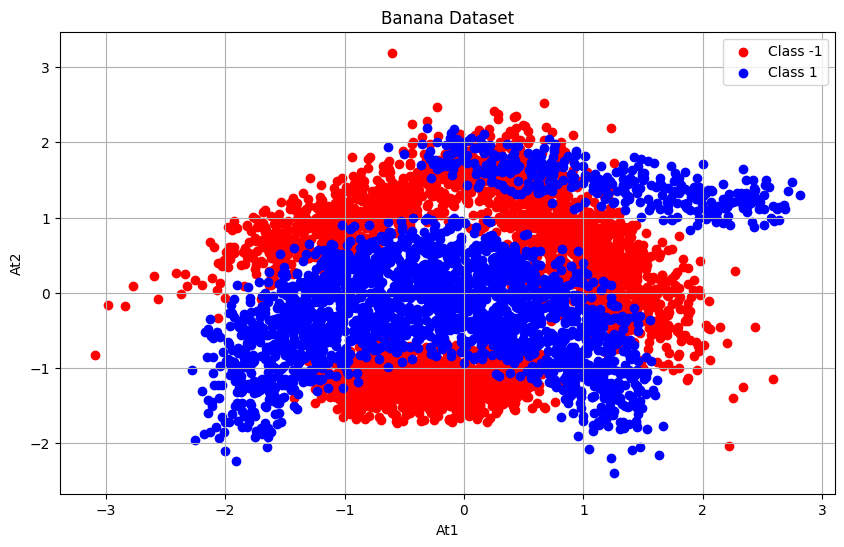

In [4]:
X = df[['At1', 'At2']].values
y = df['Class'].values

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Banana Dataset')
plt.xlabel('At1')
plt.ylabel('At2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# convert all -1 class to 0
y = np.where(y == -1, 0, y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 400/5300, stratify=y)
training_inputs = [np.reshape(x, (len(x), 1)) for x in X_train]
training_results = [np.reshape(y, (1, 1)) for y in y_train]
training_data = list(zip(training_inputs, training_results))

X_train_validation, X_test_test, y_train_validation, y_test_test = train_test_split(X_test, y_test, random_state=0, train_size = 1000/4900, stratify=y_test)
validation_inputs = [np.reshape(x, (len(x), 1)) for x in X_train_validation]
validation_results = [np.reshape(y, (1, 1)) for y in y_train_validation]
validation_data = list(zip(validation_inputs, validation_results))
test_inputs = [np.reshape(x, (len(x), 1)) for x in X_test_test]
test_results = [np.reshape(y, (1, 1)) for y in y_test_test]
test_data = list(zip(test_inputs, test_results))

In [6]:
net = Network([2, 8, 1])

In [7]:
net.train(training_data, 200, 0.1)

In [8]:
Network.test(net, test_data)

Accuracy:  0.868733850129199


0.868733850129199

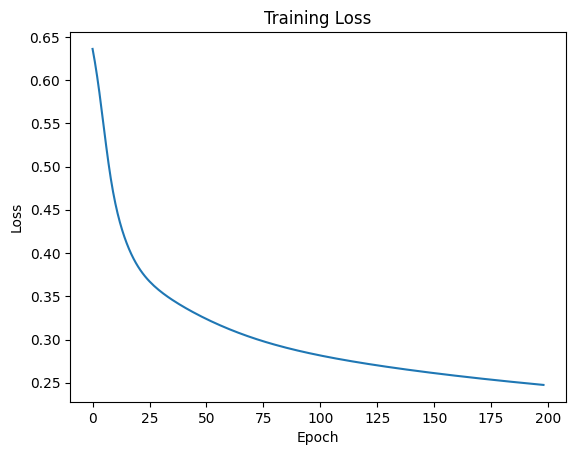

In [9]:
import matplotlib.pyplot as plt

def plot_loss(log_file_name):
    with open(log_file_name, 'r') as f:
        lines = f.readlines()

    losses = [float(line.split(':')[1]) for line in lines[2:]]

    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

plot_loss("log.txt")

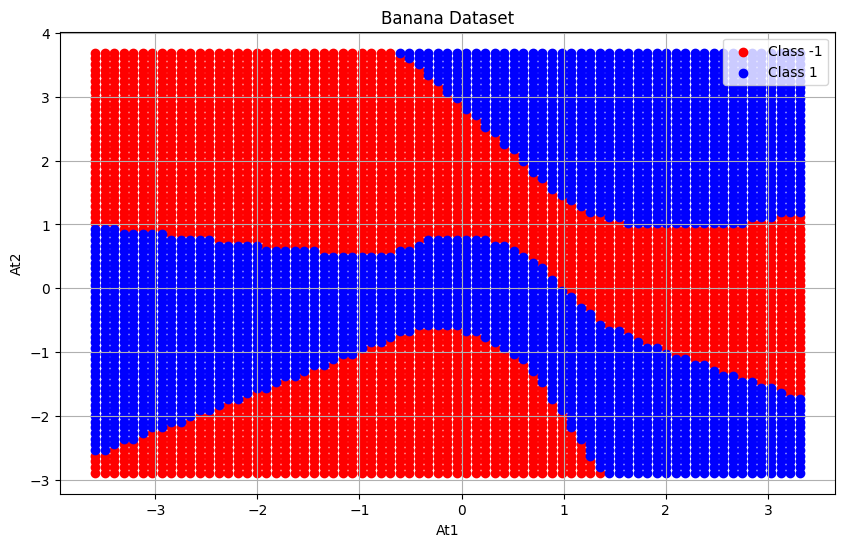

In [10]:
x_min = X[:, 0].min() - 0.5
x_max = X[:, 0].max() + 0.5
y_min = X[:, 1].min() - 0.5
y_max = X[:, 1].max() + 0.5

xx, yy = np.mgrid[x_min:x_max:75j, y_min:y_max:75j]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = np.array([net.feedforward(np.reshape(x, (2, 1))) for x in grid])
probs = np.where(probs > 0, 1, -1)
probs = probs.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(grid[probs == -1][:, 0], grid[probs == -1][:, 1], color='red', label='Class -1')
plt.scatter(grid[probs == 1][:, 0], grid[probs == 1][:, 1], color='blue', label='Class 1')
plt.title('Banana Dataset')
plt.xlabel('At1')
plt.ylabel('At2')
plt.legend()
plt.grid(True)

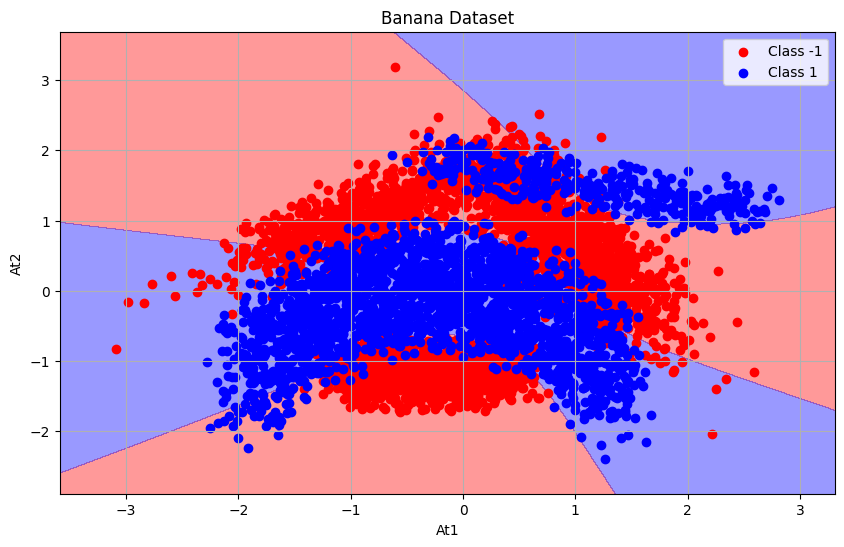

In [11]:
x_min = X[:, 0].min() - 0.5
x_max = X[:, 0].max() + 0.5
y_min = X[:, 1].min() - 0.5
y_max = X[:, 1].max() + 0.5

xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = np.array([net.feedforward(np.reshape(x, (2, 1))) for x in grid])
probs = probs.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, probs, levels=[-np.inf, 0, np.inf], colors=['red', 'blue'], alpha=0.4)
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Banana Dataset')
plt.xlabel('At1')
plt.ylabel('At2')
plt.legend()
plt.grid(True)

In [18]:
neurons_in_hidden_layer = [6, 7, 8, 9, 10, 11, 12]
num_trials = 10

accuracies = []

for n in neurons_in_hidden_layer:
    trial_accuracies = []
    for i in range(num_trials):
        net = Network([2, n, 1])
        print(f"Number of neurons in hidden layer: {n}, iteration: {i+1}")
        net.train(training_data, 100, 0.1)
        accuracy = Network.test(net, validation_data)
        trial_accuracies.append(accuracy)
    average_accuracy = np.mean(trial_accuracies)
    accuracies.append(average_accuracy)

Number of neurons in hidden layer: 6, iteration: 1
Accuracy:  0.5943579766536965
Number of neurons in hidden layer: 6, iteration: 2
Accuracy:  0.6400778210116731
Number of neurons in hidden layer: 6, iteration: 3
Accuracy:  0.6653696498054474
Number of neurons in hidden layer: 6, iteration: 4
Accuracy:  0.7149805447470817
Number of neurons in hidden layer: 6, iteration: 5
Accuracy:  0.6721789883268483
Number of neurons in hidden layer: 6, iteration: 6
Accuracy:  0.5924124513618677
Number of neurons in hidden layer: 6, iteration: 7
Accuracy:  0.75
Number of neurons in hidden layer: 6, iteration: 8
Accuracy:  0.6099221789883269
Number of neurons in hidden layer: 6, iteration: 9
Accuracy:  0.7315175097276264
Number of neurons in hidden layer: 6, iteration: 10
Accuracy:  0.796692607003891
Number of neurons in hidden layer: 7, iteration: 1
Accuracy:  0.7947470817120622
Number of neurons in hidden layer: 7, iteration: 2
Accuracy:  0.42217898832684825
Number of neurons in hidden layer: 7, ite

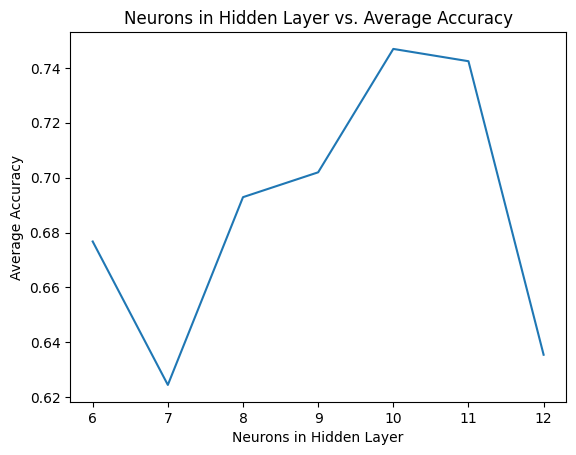

In [19]:
plt.plot(neurons_in_hidden_layer, accuracies)
plt.xlabel('Neurons in Hidden Layer')
plt.ylabel('Average Accuracy')
plt.title('Neurons in Hidden Layer vs. Average Accuracy')
plt.show()  

## Multilayer Architecture with Gradient Checking

In [99]:
net2 = Network([2, 8, 8, 1])

In [100]:
net2.train(training_data, 500, 0.06)

In [101]:
Network.test(net2, test_data)

Accuracy:  0.8907692307692308


0.8907692307692308

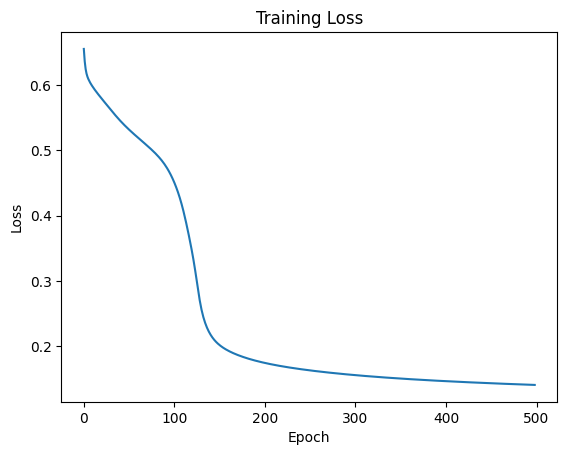

In [102]:
import matplotlib.pyplot as plt

def plot_loss(log_file_name):
    with open(log_file_name, 'r') as f:
        lines = f.readlines()

    losses = [float(line.split(':')[1]) for line in lines[2:]]

    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

plot_loss("log.txt")